In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

# mnist = fetch_openml('mnist_784')
# X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.values.reshape((-1, 28, 28))],0).astype(np.uint8)
# y_vec = mnist.target.astype(np.uint8)

In [4]:
# np.save("image_X.npy", X_vec)
# np.save("image_y.npy", y_vec)

In [2]:
X_vec = np.load("image_X.npy")
y_vec = np.load("image_y.npy")
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.60)

In [3]:
import sys
sys.path.append('../..')
from slime import lime_image
from slime import explanation
from lime.wrappers.scikit_image import SegmentationAlgorithm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [14]:
simple_rf_pipeline.fit(X_train, y_train)

explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

explanation = explainer.explain_instance(X_test[0], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Positive/Negative Regions for 4')

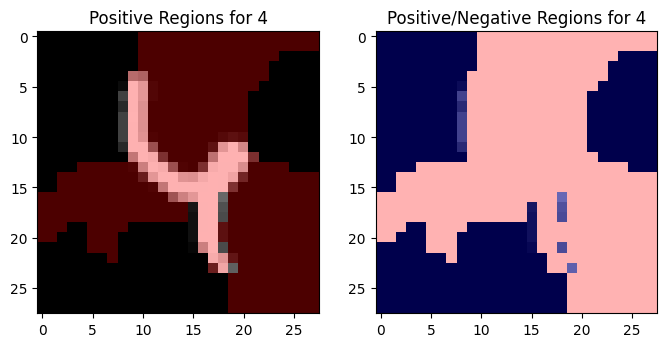

In [6]:
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))


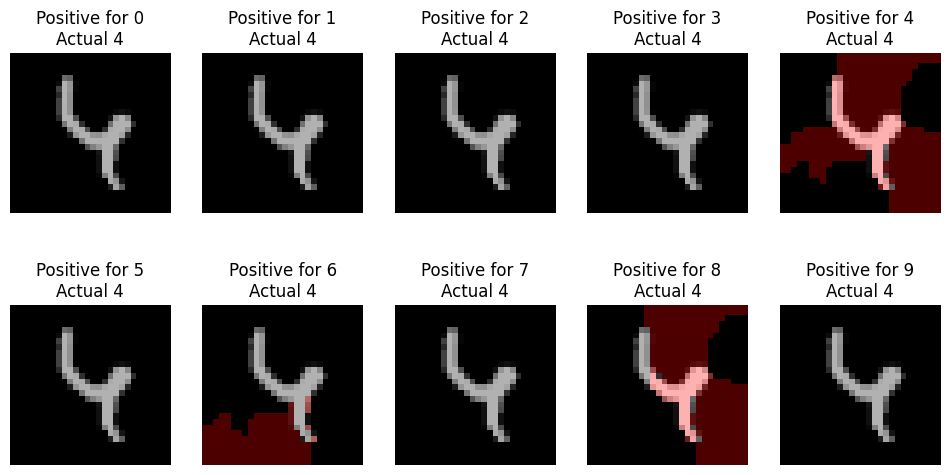

In [7]:
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[0]))
    c_ax.axis('off')

In [7]:
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
simple_rf_pipeline.fit(X_train, y_train)

explainer = lime_image.LimeImageExplainer(verbose=False)

jaccard_lime = []

for seed in range(20):
    np.random.seed(seed + 1)
    i = np.random.randint(0, X_test.shape[0])
    
    result = []
    for _ in range(20):
        exp = explainer.explain_instance(X_test[i], simple_rf_pipeline.predict_proba, num_features=5, num_samples = 1000)
        result.append([i[0] for i in exp.as_list()])
        
    jaccard = []
    for num in range(1, 6):
        temp = []
        for j in range(20 - 1):
            for k in range(j + 1, 20):
                A = result[j][:num]
                B = result[k][:num]
                temp.append(len(set(A).intersection(set(B))) / float(len(set(A).union(set(B)))))
        jaccard.append(np.mean(temp))

    jaccard_lime.append(jaccard)
    
print(np.mean(jaccard_lime, axis = 0))

  0%|          | 0/1000 [00:00<?, ?it/s]

AttributeError: 'ImageExplanation' object has no attribute 'as_list'